In [ ]:
# Instalar bibliotecas necessárias
!pip install tensorflow pillow matplotlib scikit-learn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import Counter
from sklearn.model_selection import train_test_split

print(f"TensorFlow versão: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

TensorFlow versão: 2.19.0
GPU disponível: []


In [ ]:
# Configurações
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Montar Google Drive (suas imagens devem estar aqui)
from google.colab import drive
drive.mount('/content/drive')

# Defina o caminho para suas imagens
# Estrutura esperada:
# /content/drive/MyDrive/flores/
#   ├── margarida/
#   │   ├── img1.jpg
#   │   └── img2.jpg
#   ├── rosa/
#   │   ├── img1.jpg
#   │   └── img2.jpg
#   └── girassol/
#       ├── img1.jpg
#       └── img2.jpg

DATA_DIR = '/content/drive/MyDrive/flores'  # AJUSTE ESTE CAMINHO!

# Verificar estrutura
print("📂 Categorias encontradas:")
class_names = sorted(os.listdir(DATA_DIR))
for idx, class_name in enumerate(class_names):
    num_images = len(os.listdir(os.path.join(DATA_DIR, class_name)))
    print(f"  {idx+1}. {class_name}: {num_images} imagens")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Categorias encontradas:
  1. bellflower: 899 imagens
  2. iris: 1054 imagens
  3. rose: 999 imagens
  4. sunflower: 1027 imagens


In [ ]:
# Data Augmentation para melhorar generalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% treino, 20% validação
)

# Gerador de treino
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Gerador de validação
validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Salvar mapeamento de classes
class_indices = train_generator.class_indices
num_classes = len(class_indices)
print(f"\n🎯 Total de classes: {num_classes}")
print(f"Mapeamento: {class_indices}")

Found 3186 images belonging to 4 classes.
Found 793 images belonging to 4 classes.

🎯 Total de classes: 4
Mapeamento: {'bellflower': 0, 'iris': 1, 'rose': 2, 'sunflower': 3}


In [ ]:
# Carregar MobileNetV2 pré-treinado
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar camadas do modelo base
base_model.trainable = False

# Criar modelo customizado
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compilar
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(
    'best_flower_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Treinar modelo
print("\n🔥 Iniciando treinamento...\n")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Salvar modelo final
model.save('flower_classifier_final.h5')
print("\n✅ Modelo salvo com sucesso!")


🔥 Iniciando treinamento...

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5396 - loss: 1.1199
Epoch 1: val_accuracy improved from -inf to 0.89407, saving model to best_flower_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 674s 7s/step - accuracy: 0.5409 - loss: 1.1169 - val_accuracy: 0.8941 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8407 - loss: 0.4111
Epoch 2: val_accuracy improved from 0.89407 to 0.90668, saving model to best_flower_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.8409 - loss: 0.4109 - val_accuracy: 0.9067 - val_loss: 0.2377 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8840 - loss: 0.3266
Epoch 3: val_accuracy improved from 0.90668 to 0.93443, saving model to best_flower_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8840 - loss: 0.3265 - val_accuracy: 0.9344 - val_loss: 0.1954 - learning_rate: 1.0000e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8952 - loss: 0.2920
Epoch 4: val_accuracy improved from 0.93443 to 0.94578, saving model to best_flower_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8952 - loss: 0.2920 - val_accuracy: 0.9458 - val_loss: 0.1667 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9063 - loss: 0.2516
Epoch 5: val_accuracy did not improve from 0.94578
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9063 - loss: 0.2516 - val_accuracy: 0.9395 - val_loss: 0.1621 - learning_rate: 1.0000e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9117 - loss: 0.2441
Epoch 6: val_accuracy improved from 0.94578 to 0.95965, saving model to best_flower_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9117 - loss: 0.2441 - val_accuracy: 0.9596 - val_loss: 0.1305 - learning_rate: 1.0000e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9199 - loss: 0.2135
Epoch 7: val_accuracy did not improve from 0.95965
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9199 - loss: 0.2135 - val_accuracy: 0.9458 - val_loss: 0.1313 - learning_rate: 1.0000e-04
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9295 - loss: 0.2059
Epoch 8: val_accuracy did not improve from 0.95965
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9295 - loss: 0.2058 - val_accuracy: 0.9559 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9325 - loss: 0.1834
Epoch 9: val_accuracy did not improve from 0.95965
100/100 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9325 - loss: 0.1835 - val_accuracy: 0.9559 - val_loss: 0.1237 - learning_rate: 1.0000e-04
Epoch 10

100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9355 - loss: 0.1843 - val_accuracy: 0.9609 - val_loss: 0.1208 - learning_rate: 1.0000e-04
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9363 - loss: 0.1760
Epoch 12: val_accuracy did not improve from 0.96091
100/100 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9363 - loss: 0.1760 - val_accuracy: 0.9609 - val_loss: 0.1194 - learning_rate: 1.0000e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - loss: 0.1712
Epoch 13: val_accuracy did not improve from 0.96091
100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9387 - loss: 0.1712 - val_accuracy: 0.9596 - val_loss: 0.1165 - learning_rate: 1.0000e-04
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9398 - loss: 0.1675
Epoch 14: val_accuracy did not improve from 0.96091
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9398 - loss: 0.1676 - val_accuracy: 0.9584 - val_loss: 0.1098 - learning_rate: 1.0000e-04
Ep

100/100 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.9406 - loss: 0.1627 - val_accuracy: 0.9647 - val_loss: 0.1001 - learning_rate: 1.0000e-04
Epoch 17/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9364 - loss: 0.1647
Epoch 17: val_accuracy did not improve from 0.96469
100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9364 - loss: 0.1646 - val_accuracy: 0.9470 - val_loss: 0.1200 - learning_rate: 1.0000e-04
Epoch 18/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9429 - loss: 0.1566
Epoch 18: val_accuracy did not improve from 0.96469
100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9429 - loss: 0.1566 - val_accuracy: 0.9571 - val_loss: 0.1171 - learning_rate: 1.0000e-04
Epoch 19/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9501 - loss: 0.1325
Epoch 19: val_accuracy did not improve from 0.96469

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9500 - loss: 0

100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9510 - loss: 0.1297 - val_accuracy: 0.9660 - val_loss: 0.1024 - learning_rate: 5.0000e-05



✅ Modelo salvo com sucesso!


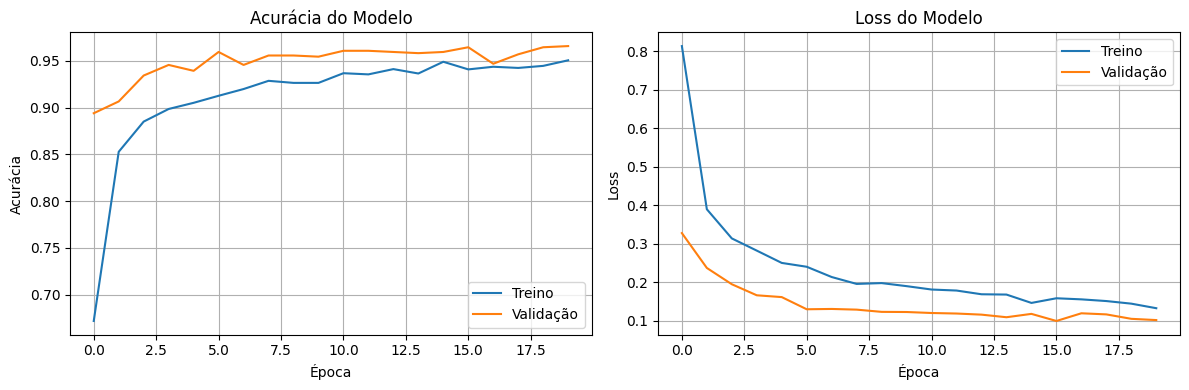

In [ ]:
# Plotar curvas de treino
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def get_dominant_color(image_path, k=3):
    """
    Extrai a cor predominante da imagem
    """
    img = Image.open(image_path).resize((100, 100))
    img_array = np.array(img)

    # Reshape para lista de pixels
    pixels = img_array.reshape(-1, 3)

    # Encontrar cores mais comuns
    pixel_list = [tuple(pixel) for pixel in pixels]
    most_common = Counter(pixel_list).most_common(5)

    # Excluir cores muito escuras ou claras (provavelmente fundo)
    valid_colors = []
    for color, count in most_common:
        r, g, b = color
        brightness = (r + g + b) / 3
        if 30 < brightness < 225:
            valid_colors.append(color)

    if valid_colors:
        r, g, b = valid_colors[0]
    else:
        r, g, b = most_common[0][0]

    # Nomear cor
    if r > 200 and g < 100 and b < 100:
        color_name = "Vermelha"
    elif r > 200 and g > 150 and b < 100:
        color_name = "Laranja"
    elif r > 200 and g > 200 and b < 100:
        color_name = "Amarela"
    elif r < 100 and g > 150 and b < 100:
        color_name = "Verde"
    elif r < 100 and g < 100 and b > 200:
        color_name = "Azul"
    elif r > 150 and g < 100 and b > 150:
        color_name = "Roxa"
    elif r > 200 and g > 150 and b > 150:
        color_name = "Rosa"
    elif r > 200 and g > 200 and b > 200:
        color_name = "Branca"
    else:
        color_name = "Multicolorida"

    return color_name, (r, g, b)

In [ ]:
def predict_flower(image_path, model, class_indices):
    """
    Prediz flor com nome, cor, espécie e confiança
    """
    # Carregar e preprocessar imagem
    img = keras.preprocessing.image.load_img(
        image_path,
        target_size=IMG_SIZE
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predição
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Obter nome da classe
    idx_to_class = {v: k for k, v in class_indices.items()}
    flower_name = idx_to_class[predicted_class_idx]

    # Extrair cor
    color_name, rgb = get_dominant_color(image_path)

    # Resultado
    result = {
        'nome': flower_name.title(),
        'especie': flower_name.title(),
        'cor': color_name,
        'cor_rgb': rgb,
        'confianca': f"{confidence:.2f}%"
    }

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Imagem Original')

    plt.subplot(1, 2, 2)
    plt.barh(range(len(predictions[0])), predictions[0])
    plt.yticks(range(len(predictions[0])),
               [idx_to_class[i].title() for i in range(len(predictions[0]))])
    plt.xlabel('Probabilidade')
    plt.title('Predições')
    plt.tight_layout()
    plt.show()

    # Printar resultado
    print("\n" + "="*50)
    print("RESULTADO DA CLASSIFICAÇÃO")
    print("="*50)
    print(f"📌 Nome: {result['nome']}")
    print(f"🔬 Espécie: {result['especie']}")
    print(f"🎨 Cor: {result['cor']} (RGB: {result['cor_rgb']})")
    print(f"📊 Confiança: {result['confianca']}")
    print("="*50 + "\n")

    return result

/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


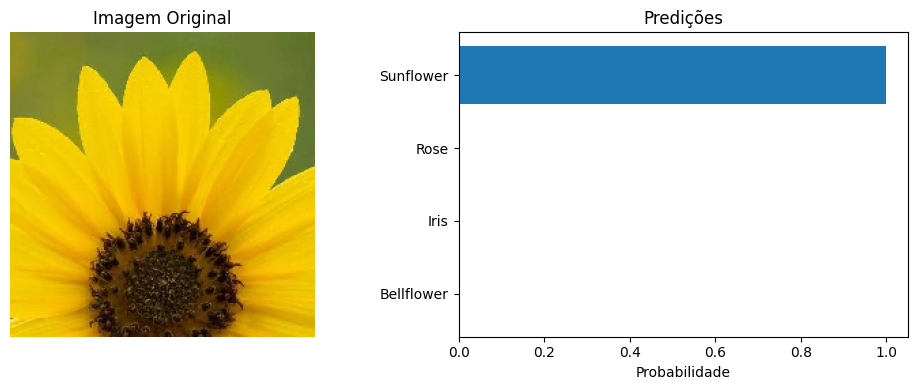


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Sunflower
🔬 Espécie: Sunflower
🎨 Cor: Laranja (RGB: (np.uint8(244), np.uint8(207), np.uint8(1)))
📊 Confiança: 99.96%



In [ ]:
# Carregar modelo treinado
model = keras.models.load_model('flower_classifier_final.h5')

# Testar com uma imagem cire uma arquivo como " teste " e adcicione o nome da imagem ex: imagem.png etc.
test_image_path = '/content/drive/MyDrive/flores/teste/images.webp'  # AJUSTE!

resultado = predict_flower(test_image_path, model, class_indices)


📸 Processando: download.jpeg


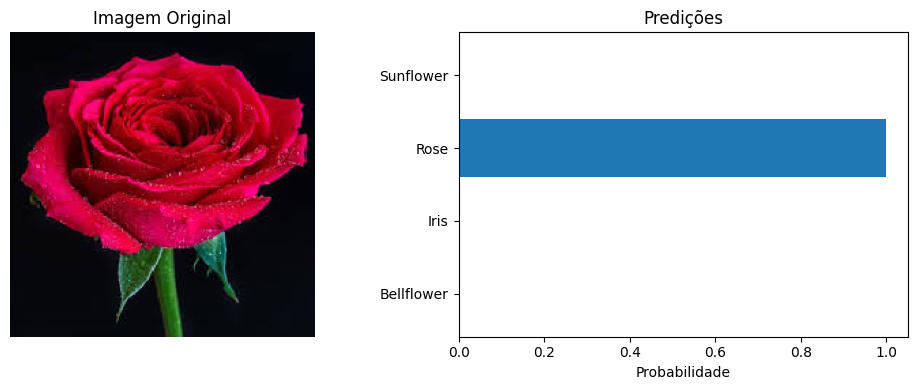


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Multicolorida (RGB: (np.uint8(6), np.uint8(7), np.uint8(12)))
📊 Confiança: 99.98%


📸 Processando: download (1).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


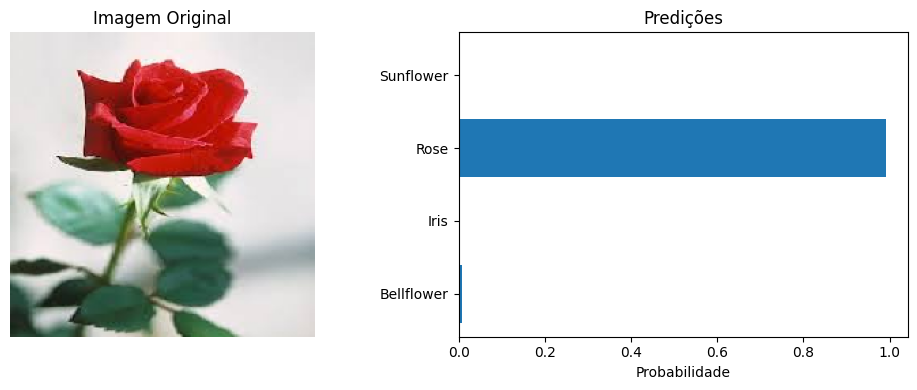


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Rosa (RGB: (np.uint8(229), np.uint8(228), np.uint8(226)))
📊 Confiança: 99.24%


📸 Processando: download (2).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


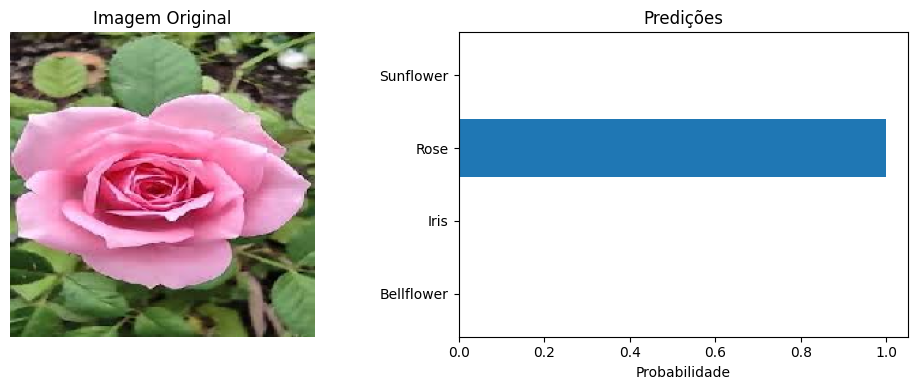


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Multicolorida (RGB: (np.uint8(130), np.uint8(169), np.uint8(124)))
📊 Confiança: 100.00%


📸 Processando: download (3).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


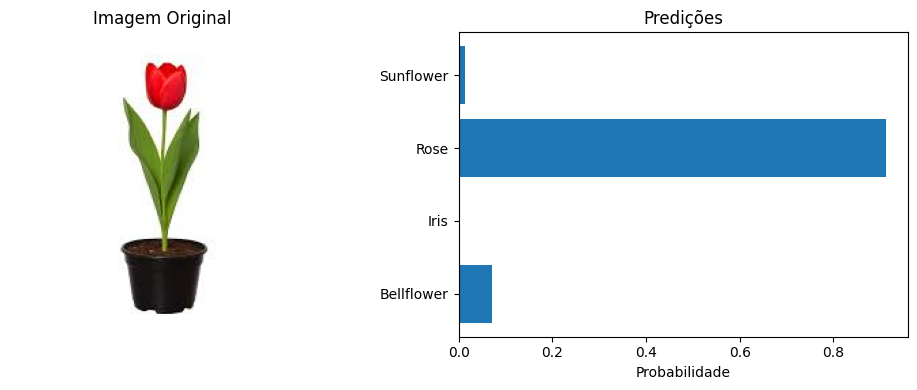


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Rosa (RGB: (np.uint8(255), np.uint8(255), np.uint8(255)))
📊 Confiança: 91.30%


📸 Processando: download (4).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


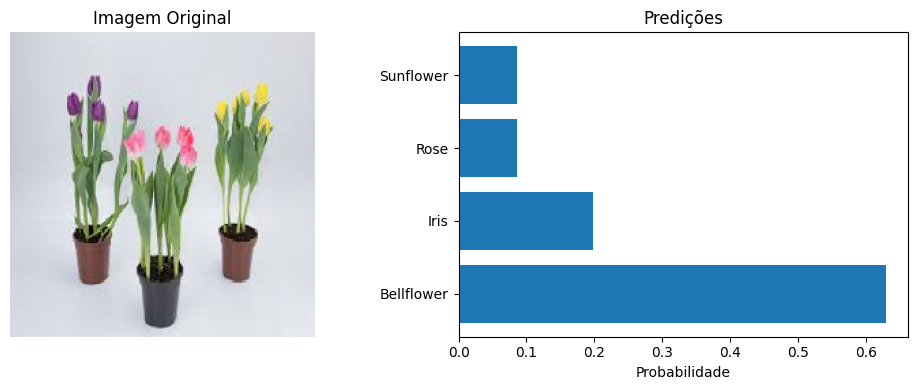


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Bellflower
🔬 Espécie: Bellflower
🎨 Cor: Rosa (RGB: (np.uint8(218), np.uint8(221), np.uint8(228)))
📊 Confiança: 62.97%


📸 Processando: download (5).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


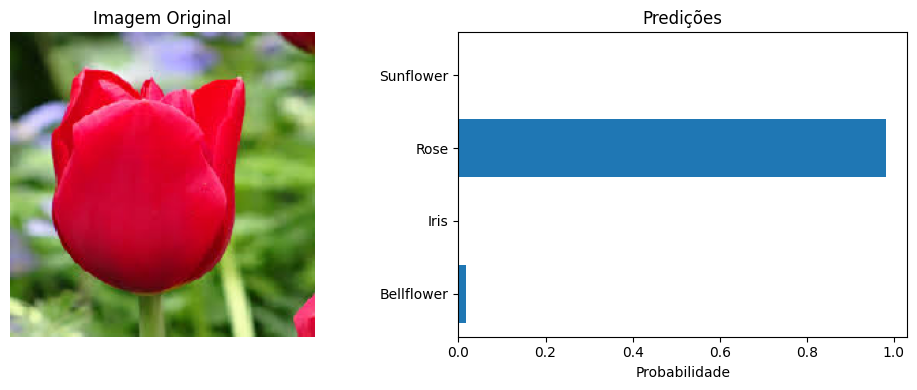


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Multicolorida (RGB: (np.uint8(14), np.uint8(28), np.uint8(3)))
📊 Confiança: 98.15%


📸 Processando: download (6).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


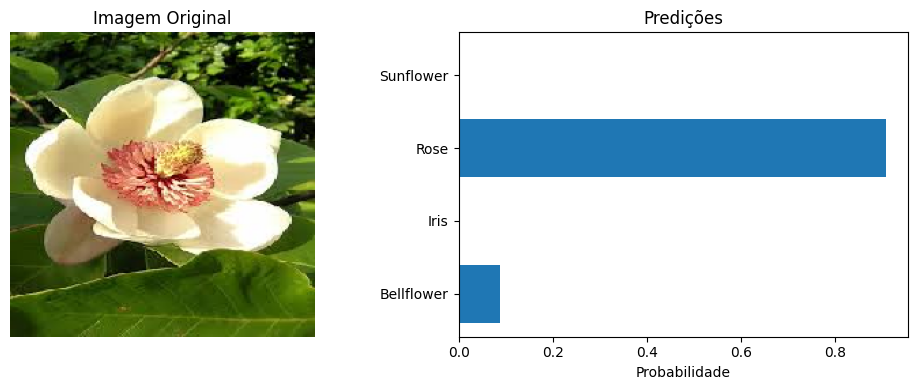


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Rose
🔬 Espécie: Rose
🎨 Cor: Rosa (RGB: (np.uint8(254), np.uint8(254), np.uint8(254)))
📊 Confiança: 90.84%


📸 Processando: download (7).jpeg


/tmp/ipython-input-2438198377.py:19: RuntimeWarning: overflow encountered in scalar add
  brightness = (r + g + b) / 3


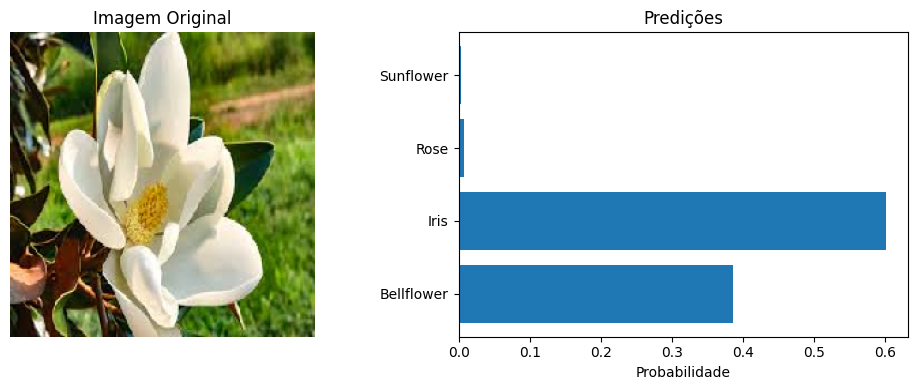


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Iris
🔬 Espécie: Iris
🎨 Cor: Rosa (RGB: (np.uint8(230), np.uint8(223), np.uint8(204)))
📊 Confiança: 60.19%


📸 Processando: download (8).jpeg


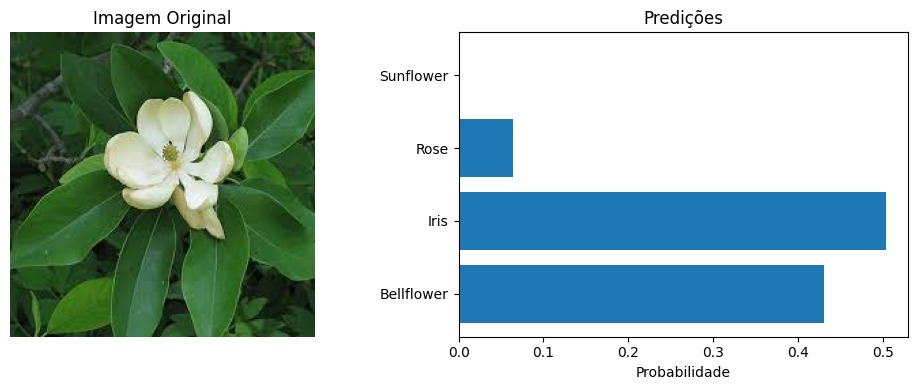


🌸 RESULTADO DA CLASSIFICAÇÃO
📌 Nome: Iris
🔬 Espécie: Iris
🎨 Cor: Multicolorida (RGB: (np.uint8(52), np.uint8(111), np.uint8(47)))
📊 Confiança: 50.43%



In [ ]:
def predict_batch(folder_path, model, class_indices, max_images=10):
    """
    Prediz múltiplas imagens de uma pasta
    """
    results = []
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files[:max_images]:
        img_path = os.path.join(folder_path, img_file)
        print(f"\n📸 Processando: {img_file}")
        result = predict_flower(img_path, model, class_indices)
        results.append(result)

    return results

# Testar com uma imagem cire uma arquivo como " teste ".
test_folder = '/content/drive/MyDrive/flores/teste'  # AJUSTE!
batch_results = predict_batch(test_folder, model, class_indices)

In [ ]:
# Descongelar últimas camadas do modelo base
base_model.trainable = True

# Congelar todas exceto as últimas 20 camadas
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompilar com learning rate menor
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar mais 10 épocas
print("\n🔥 Fine-tuning...\n")
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

model.save('flower_classifier_finetuned.h5')
print("\n✅ Fine-tuning completo!")